# Phase 2: Cross-City Transfer Evaluation

**Project:** Tree Species Classification - Cross-City Transfer Learning  
**Phase:** 2 (Transfer Evaluation & Algorithm Selection)  
**Date:** 20. Januar 2026  
**Author:** Silas Pignotti

---

## 1. OVERVIEW & METHODOLOGY

### 1.1 Purpose

This notebook conducts a **systematic evaluation of cross-city transfer performance** to identify the best algorithm and training setup for Phase 3.

**Goals:**
1. Compare transfer robustness: XGBoost vs. 1D-CNN
2. Identify best training setup: Berlin, Hamburg, or Combined
3. Quantify transfer loss vs. Single-City Baseline
4. Select Champion Configuration for Phase 3 Fine-Tuning

**Strategy:** Fast evaluation on 50k subsamples with 3-Fold Spatial CV, using Phase 1 HP configurations.

**Research Questions:**
- Q1: Which algorithm generalizes better across cities?
- Q2: Does multi-city training (Combined) improve transfer?
- Q3: How much performance is lost when transferring to new cities?

### 1.2 Workflow

```
[SECTION 5: TRANSFER EXPERIMENTS]
├── 5.1: Berlin → Rostock (XGBoost + 1D-CNN)
├── 5.2: Hamburg → Rostock (XGBoost + 1D-CNN)
└── 5.3: Combined → Rostock (XGBoost + 1D-CNN)

    ↓

[SECTION 6: RESULTS & COMPARISON]
├── 6.1: Performance Matrix (3 Setups × 2 Models)
├── 6.2: Transfer Loss Analysis
├── 6.3: Algorithm Selection
└── 6.4: Setup Selection

    ↓

[OUTPUT: selected_transfer_setup.json, transfer_comparison.csv]
```

### 1.3 Expected Outputs

| File | Type | Description |
|------|------|-------------|
| `selected_transfer_setup.json` | JSON | Champion algorithm + best training setup |
| `transfer_comparison.csv` | CSV | All 6 experiments (3 setups × 2 models) |
| `transfer_loss_analysis.csv` | CSV | Delta vs. Single-City Baseline |
| `genus_wise_transfer.csv` | CSV | Per-genus transfer performance |
| `setup_algorithm_heatmap.png` | PNG | Performance matrix visualization |
| `transfer_loss_barplot.png` | PNG | Loss quantification |

---

## 2. SETUP & IMPORTS

### 2.1 Packages & Environment

In [36]:
# Install required packages
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn --quiet
!pip install torch torchvision --quiet

In [37]:
# Standard imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json
from pathlib import Path
from datetime import datetime

# Scikit-learn
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report, confusion_matrix
)

# XGBoost
import xgboost as xgb

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("Imports successful")
print(f"  - scikit-learn: {sklearn.__version__}")
print(f"  - xgboost: {xgb.__version__}")
print(f"  - torch: {torch.__version__}")

Imports successful
  - scikit-learn: 1.6.1
  - xgboost: 3.1.2
  - torch: 2.9.0+cu126


In [38]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.2 Visualization & Utility Functions

In [39]:
# Publication style setup
PUBLICATION_STYLE = {
    'style': 'seaborn-v0_8-whitegrid',
    'figsize': (12, 7),
    'dpi_export': 300,
}

def setup_publication_style():
    plt.rcdefaults()
    plt.style.use(PUBLICATION_STYLE['style'])
    sns.set_palette('Set2')
    plt.rcParams['figure.figsize'] = PUBLICATION_STYLE['figsize']
    plt.rcParams['savefig.dpi'] = PUBLICATION_STYLE['dpi_export']
    print("Publication Style configured")

setup_publication_style()

Publication Style configured


In [40]:
# Utility functions

def log_step(step_name):
    """Log execution step with timestamp."""
    timestamp = datetime.now().strftime("%H:%M:%S")
    print(f"\n{'='*70}")
    print(f"[{timestamp}] {step_name}")
    print(f"{'='*70}")

def evaluate_model(y_true, y_pred, y_train_pred=None, y_train_true=None, prefix=""):
    """Calculate comprehensive metrics for model evaluation."""

    # Validation metrics
    val_f1_macro = f1_score(y_true, y_pred, average='macro')
    val_f1_weighted = f1_score(y_true, y_pred, average='weighted')
    val_accuracy = accuracy_score(y_true, y_pred)

    metrics = {
        f'{prefix}val_f1_macro': val_f1_macro,
        f'{prefix}val_f1_weighted': val_f1_weighted,
        f'{prefix}val_accuracy': val_accuracy,
    }

    # Training metrics (if provided)
    if y_train_pred is not None and y_train_true is not None:
        train_f1_macro = f1_score(y_train_true, y_train_pred, average='macro')
        gap = (train_f1_macro - val_f1_macro) * 100

        metrics[f'{prefix}train_f1_macro'] = train_f1_macro
        metrics[f'{prefix}train_val_gap_pct'] = gap

    return metrics

def save_json(data, filepath):
    """Save dictionary as JSON with nice formatting."""
    with open(filepath, 'w') as f:
        json.dump(data, f, indent=2, default=str)
    print(f"Saved: {filepath}")

def compute_genus_wise_f1(y_true, y_pred, label_encoder):
    """Compute F1 score per genus."""
    from sklearn.metrics import f1_score

    genus_f1 = {}
    for genus_idx, genus_name in enumerate(label_encoder.classes_):
        # Binary F1 for this genus
        y_true_binary = (y_true == genus_idx).astype(int)
        y_pred_binary = (y_pred == genus_idx).astype(int)

        if y_true_binary.sum() > 0:
            genus_f1[genus_name] = f1_score(y_true_binary, y_pred_binary, zero_division=0)
        else:
            genus_f1[genus_name] = np.nan

    return genus_f1

print("Utility functions defined")

Utility functions defined


---

## 3. CONFIGURATION & PARAMETERS

### 3.1 Paths

In [41]:
BASE_DIR = Path("/content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit")

# Input Data (From Phase 1 Data Prep)
INPUT_DATA_DIR = BASE_DIR / "data/03_experiments/01_phase_1/00_data_preparation/data"
BERLIN_TRAIN_FILE = INPUT_DATA_DIR / "berlin_20m_edge_top50_train.parquet"
HAMBURG_TRAIN_FILE = INPUT_DATA_DIR / "hamburg_20m_edge_top50_train.parquet"
ROSTOCK_ZERO_SHOT_FILE = INPUT_DATA_DIR / "rostock_20m_edge_top50_zero_shot.parquet"

# Phase 1 Results (Champion Configs)
PHASE_1_METADATA_DIR = BASE_DIR / "data/03_experiments/01_phase_1/01_algorithm_ranking/metadata"
SELECTED_ALGORITHMS_FILE = PHASE_1_METADATA_DIR / "selected_algorithms.json"
XGB_BEST_PARAMS_FILE = PHASE_1_METADATA_DIR / "xgb_best_params.json"

# Phase 0 Metadata (Selected Features)
PHASE_0_METADATA_DIR = BASE_DIR / "data/03_experiments/00_phase_0/03_experiment_feature_reduction/metadata"
SELECTED_FEATURES_FILE = PHASE_0_METADATA_DIR / "selected_features.json"

# Experiment Output (Phase 2 - Transfer Evaluation)
OUTPUT_DIR = BASE_DIR / "data/03_experiments/02_phase_2/01_transfer_evaluation"
OUTPUT_DATA = OUTPUT_DIR / "data"
OUTPUT_METADATA = OUTPUT_DIR / "metadata"
OUTPUT_PLOTS = OUTPUT_DIR / "plots"

# Create directories
for path in [OUTPUT_DATA, OUTPUT_METADATA, OUTPUT_PLOTS]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Input data directory: {INPUT_DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Base directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit
Input data directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/01_phase_1/00_data_preparation/data
Output directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/02_phase_2/01_transfer_evaluation


### 3.2 Experiment Parameters

In [42]:
# Data Configuration
LABEL_COL = 'genus_latin'
METADATA_COLS = ['block_id', 'outlier_level', 'tree_id', 'tree_type', 'city']

EXPERIMENT_PARAMS = {
    # Dataset
    'dataset': '20m_edge',
    'features': 'top_50',
    'sample_size': 35000,
    'stratify_by': LABEL_COL,

    # Cross-Validation
    'cv_folds': 3,
    'cv_type': 'GroupKFold (Spatial Block CV)',

    # Random Seeds
    'random_seed': 42,

    # Transfer Test
    'target_city': 'Rostock',

    # Phase 1 Baseline (for comparison)
    'phase_1_berlin_val_f1': 0.5805,  # XGBoost Phase 1 Single-City
}

# Set random seeds
np.random.seed(EXPERIMENT_PARAMS['random_seed'])
torch.manual_seed(EXPERIMENT_PARAMS['random_seed'])

# Display parameters
print("Experiment Parameters:")
print("-" * 70)
for key, value in EXPERIMENT_PARAMS.items():
    print(f"  {key:<30} {str(value):<20}")

print(f"\nData Configuration:")
print(f"  Label Column: {LABEL_COL}")
print(f"  Metadata: {METADATA_COLS}")

Experiment Parameters:
----------------------------------------------------------------------
  dataset                        20m_edge            
  features                       top_50              
  sample_size                    35000               
  stratify_by                    genus_latin         
  cv_folds                       3                   
  cv_type                        GroupKFold (Spatial Block CV)
  random_seed                    42                  
  target_city                    Rostock             
  phase_1_berlin_val_f1          0.5805              

Data Configuration:
  Label Column: genus_latin
  Metadata: ['block_id', 'outlier_level', 'tree_id', 'tree_type', 'city']


### 3.3 Load Phase 1 Champion Configurations

In [43]:
log_step("LOADING: Phase 1 Champion Configurations")

# Load selected algorithms from Phase 1
with open(SELECTED_ALGORITHMS_FILE, 'r') as f:
    phase_1_selection = json.load(f)

print("Phase 1 Champions:")
print(f"  Best ML:  {phase_1_selection['best_ml']['algorithm']}")
print(f"    Val F1: {phase_1_selection['best_ml']['val_f1_macro']:.4f}")
print(f"    Gap:    {phase_1_selection['best_ml']['train_val_gap_pct']:.2f}%")

print(f"  Best NN:  {phase_1_selection['best_nn']['algorithm']}")
print(f"    Val F1: {phase_1_selection['best_nn']['val_f1_macro']:.4f}")
print(f"    Gap:    {phase_1_selection['best_nn']['train_val_gap_pct']:.2f}%")

# Load XGBoost HP
with open(XGB_BEST_PARAMS_FILE, 'r') as f:
    xgb_best_params = json.load(f)

print("\nXGBoost Best Hyperparameters:")
for param, value in xgb_best_params.items():
    print(f"  {param}: {value}")

# 1D-CNN Config (from Phase 1)
CNN_PARAMS = {
    'batch_size': 128,
    'lr': 0.001,
    'epochs': 30,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print(f"\n1D-CNN Configuration:")
for param, value in CNN_PARAMS.items():
    print(f"  {param}: {value}")


[13:57:19] LOADING: Phase 1 Champion Configurations
Phase 1 Champions:
  Best ML:  XGBoost
    Val F1: 0.5805
    Gap:    41.46%
  Best NN:  1D-CNN
    Val F1: 0.5462
    Gap:    18.95%

XGBoost Best Hyperparameters:
  colsample_bytree: 0.8
  eval_metric: mlogloss
  learning_rate: 0.1
  max_depth: 8
  min_child_weight: 5
  n_estimators: 200
  n_jobs: -1
  random_state: 42
  reg_alpha: 0.1
  reg_lambda: 1
  subsample: 0.8

1D-CNN Configuration:
  batch_size: 128
  lr: 0.001
  epochs: 30
  device: cuda


### 3.4 Define 1D-CNN Model (from Phase 1)

In [44]:
# 1D-CNN Model Architecture (identical to Phase 1)
class Simple1DCNN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(Simple1DCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Dynamic calculation of linear layer input size
        dummy_input = torch.zeros(1, 1, num_features)
        dummy_output = self.features(dummy_input)
        linear_input_size = dummy_output.view(1, -1).size(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linear_input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.features(x)
        x = self.classifier(x)
        return x

print("1D-CNN Model defined")

1D-CNN Model defined


---

## 4. DATA LOADING

### 4.1 Load Selected Features from Phase 0

In [45]:
log_step("LOADING: Selected Features from Phase 0")

# Load Selected Features
try:
    with open(SELECTED_FEATURES_FILE, 'r') as f:
        feature_data = json.load(f)
        if isinstance(feature_data, list):
            selected_features = feature_data
        elif isinstance(feature_data, dict):
            if 'selected_features' in feature_data:
                selected_features = feature_data['selected_features']
            elif 'features' in feature_data:
                selected_features = feature_data['features']
            else:
                selected_features = list(feature_data.keys())
        else:
            selected_features = None

    if selected_features:
        print(f"Loaded {len(selected_features)} selected features from Phase 0")
except Exception as e:
    print(f"Error loading selected features: {e}")
    selected_features = None


[13:57:19] LOADING: Selected Features from Phase 0
Loaded 50 selected features from Phase 0


### 4.2 Load and Prepare Berlin Training Data

In [46]:
log_step("LOADING: Berlin Training Data")

# Load Berlin Data
df_berlin = pd.read_parquet(BERLIN_TRAIN_FILE)
print(f"Loaded Berlin raw data: {df_berlin.shape}")

# Filter to selected features
if selected_features:
    available_features = [f for f in selected_features if f in df_berlin.columns]
    cols_to_keep = [LABEL_COL] + [c for c in METADATA_COLS if c in df_berlin.columns] + available_features
    cols_to_keep = list(dict.fromkeys(cols_to_keep))
    df_berlin = df_berlin[cols_to_keep]

print(f"Filtered to selected features: {df_berlin.shape}")

# Subsample to 50k
sample_size = min(EXPERIMENT_PARAMS['sample_size'], len(df_berlin))
df_berlin, _ = train_test_split(
    df_berlin,
    train_size=sample_size,
    stratify=df_berlin[LABEL_COL],
    random_state=EXPERIMENT_PARAMS['random_seed']
)

print(f"Berlin subsample: {len(df_berlin):,} samples")
print(f"\nLabel distribution:")
print(df_berlin[LABEL_COL].value_counts())


[13:57:19] LOADING: Berlin Training Data
Loaded Berlin raw data: (131317, 55)
Filtered to selected features: (131317, 55)
Berlin subsample: 35,000 samples

Label distribution:
genus_latin
TILIA       18529
ACER         9123
QUERCUS      4601
BETULA       1354
FRAXINUS     1067
SORBUS        326
Name: count, dtype: int64


### 4.3 Load and Prepare Hamburg Training Data

In [47]:
log_step("LOADING: Hamburg Training Data")

# Load Hamburg Data
df_hamburg = pd.read_parquet(HAMBURG_TRAIN_FILE)
print(f"Loaded Hamburg raw data: {df_hamburg.shape}")

# Filter to selected features
if selected_features:
    available_features = [f for f in selected_features if f in df_hamburg.columns]
    cols_to_keep = [LABEL_COL] + [c for c in METADATA_COLS if c in df_hamburg.columns] + available_features
    cols_to_keep = list(dict.fromkeys(cols_to_keep))
    df_hamburg = df_hamburg[cols_to_keep]

print(f"Filtered to selected features: {df_hamburg.shape}")

# Subsample to EXPERIMENT_PARAMS['sample_size'] (e.g., 50k), if df_hamburg is larger
target_sample_size = EXPERIMENT_PARAMS['sample_size']
if len(df_hamburg) > target_sample_size:
    df_hamburg, _ = train_test_split(
        df_hamburg,
        train_size=target_sample_size,
        stratify=df_hamburg[LABEL_COL],
        random_state=EXPERIMENT_PARAMS['random_seed']
    )
# Else: df_hamburg is already smaller or equal to target_sample_size, so no subsampling is needed.

print(f"Hamburg subsample: {len(df_hamburg):,} samples")
print(f"\nLabel distribution:")
print(df_hamburg[LABEL_COL].value_counts())


[13:57:20] LOADING: Hamburg Training Data
Loaded Hamburg raw data: (35468, 55)
Filtered to selected features: (35468, 55)
Hamburg subsample: 35,000 samples

Label distribution:
genus_latin
TILIA       14127
QUERCUS     11787
ACER         5351
BETULA       1556
SORBUS       1285
FRAXINUS      894
Name: count, dtype: int64


### 4.4 Create Combined Training Data

In [48]:
log_step("CREATING: Combined (Berlin + Hamburg) Training Data")

# Combine Berlin and Hamburg
df_combined = pd.concat([df_berlin, df_hamburg], ignore_index=True)
print(f"Combined raw: {df_combined.shape}")

# Subsample to 50k stratified
sample_size = min(EXPERIMENT_PARAMS['sample_size'], len(df_combined))
df_combined, _ = train_test_split(
    df_combined,
    train_size=sample_size,
    stratify=df_combined[LABEL_COL],
    random_state=EXPERIMENT_PARAMS['random_seed']
)

print(f"Combined subsample: {len(df_combined):,} samples")
print(f"\nLabel distribution:")
print(df_combined[LABEL_COL].value_counts())

# Check city distribution
if 'city' in df_combined.columns:
    print(f"\nCity distribution:")
    print(df_combined['city'].value_counts())


[13:57:20] CREATING: Combined (Berlin + Hamburg) Training Data
Combined raw: (70000, 55)
Combined subsample: 35,000 samples

Label distribution:
genus_latin
TILIA       16328
QUERCUS      8194
ACER         7237
BETULA       1455
FRAXINUS      980
SORBUS        806
Name: count, dtype: int64


### 4.5 Load Rostock Test Data (Zero-Shot)

In [49]:
log_step("LOADING: Rostock Zero-Shot Test Data")

# Load Rostock Data
df_rostock = pd.read_parquet(ROSTOCK_ZERO_SHOT_FILE)
print(f"Loaded Rostock raw data: {df_rostock.shape}")

# Filter to selected features
if selected_features:
    available_features = [f for f in selected_features if f in df_rostock.columns]
    cols_to_keep = [LABEL_COL] + [c for c in METADATA_COLS if c in df_rostock.columns] + available_features
    cols_to_keep = list(dict.fromkeys(cols_to_keep))
    df_rostock = df_rostock[cols_to_keep]

print(f"Filtered to selected features: {df_rostock.shape}")
print(f"\nLabel distribution:")
print(df_rostock[LABEL_COL].value_counts())


[13:57:20] LOADING: Rostock Zero-Shot Test Data
Loaded Rostock raw data: (3596, 55)
Filtered to selected features: (3596, 55)

Label distribution:
genus_latin
TILIA       1505
ACER         851
BETULA       522
QUERCUS      295
FRAXINUS     222
SORBUS       201
Name: count, dtype: int64


---

## 5. TRANSFER EXPERIMENTS: 6 CONFIGURATIONS

### 5.1 Helper Function: Train and Evaluate Model

In [50]:
def train_and_evaluate_xgboost(X_train, y_train, groups_train, X_test, y_test, params, cv_splitter):
    """
    Train XGBoost with CV on training data, then evaluate on test set.

    Returns:
        dict: CV metrics + test metrics
    """
    from sklearn.metrics import f1_score

    # Create model
    model = xgb.XGBClassifier(**params)

    # CV evaluation
    cv_scores = []
    for train_idx, val_idx in cv_splitter.split(X_train, y_train, groups=groups_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Scale
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)

        # Train
        model.fit(X_tr_scaled, y_tr)

        # Predict
        y_val_pred = model.predict(X_val_scaled)
        val_f1 = f1_score(y_val, y_val_pred, average='macro')
        cv_scores.append(val_f1)

    # Final training on full train set
    scaler_final = StandardScaler()
    X_train_scaled = scaler_final.fit_transform(X_train)
    X_test_scaled = scaler_final.transform(X_test)

    model.fit(X_train_scaled, y_train)

    # Test predictions
    y_test_pred = model.predict(X_test_scaled)
    y_train_pred = model.predict(X_train_scaled)

    # Metrics
    test_metrics = evaluate_model(y_test, y_test_pred, y_train_pred, y_train)

    return {
        'cv_val_f1_mean': np.mean(cv_scores),
        'cv_val_f1_std': np.std(cv_scores),
        'test_f1_macro': test_metrics['val_f1_macro'],
        'test_f1_weighted': test_metrics['val_f1_weighted'],
        'test_accuracy': test_metrics['val_accuracy'],
        'train_f1_macro': test_metrics['train_f1_macro'],
        'train_test_gap_pct': test_metrics['train_val_gap_pct'],
        'y_test_pred': y_test_pred,
        'model': model,
        'scaler': scaler_final,
    }

def train_and_evaluate_cnn(X_train, y_train, groups_train, X_test, y_test, params, cv_splitter, num_classes):
    """
    Train 1D-CNN with CV on training data, then evaluate on test set.
    """
    from sklearn.metrics import f1_score

    # CV evaluation
    cv_scores = []
    for train_idx, val_idx in cv_splitter.split(X_train, y_train, groups=groups_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Scale
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)

        # Datasets
        train_dataset = TensorDataset(
            torch.FloatTensor(X_tr_scaled),
            torch.LongTensor(y_tr)
        )
        val_dataset = TensorDataset(
            torch.FloatTensor(X_val_scaled),
            torch.LongTensor(y_val)
        )

        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

        # Model
        model = Simple1DCNN(num_features=X_train.shape[1], num_classes=num_classes).to(params['device'])
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])

        # Training
        model.train()
        for epoch in range(params['epochs']):
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(params['device']), labels.to(params['device'])
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        val_preds = []
        with torch.no_grad():
            for inputs, _ in val_loader:
                inputs = inputs.to(params['device'])
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())

        val_f1 = f1_score(y_val, val_preds, average='macro')
        cv_scores.append(val_f1)

    # Final training on full train set
    scaler_final = StandardScaler()
    X_train_scaled = scaler_final.fit_transform(X_train)
    X_test_scaled = scaler_final.transform(X_test)

    train_dataset = TensorDataset(
        torch.FloatTensor(X_train_scaled),
        torch.LongTensor(y_train)
    )
    test_dataset = TensorDataset(
        torch.FloatTensor(X_test_scaled),
        torch.LongTensor(y_test)
    )

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    model_final = Simple1DCNN(num_features=X_train.shape[1], num_classes=num_classes).to(params['device'])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_final.parameters(), lr=params['lr'])

    model_final.train()
    for epoch in range(params['epochs']):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(params['device']), labels.to(params['device'])
            optimizer.zero_grad()
            outputs = model_final(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Test predictions
    model_final.eval()
    test_preds = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(params['device'])
            outputs = model_final(inputs)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())

    # Train predictions (for gap) - Use shuffle=False to match y_train order!
    train_eval_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=False)

    train_preds = []
    with torch.no_grad():
        for inputs, _ in train_eval_loader:
            inputs = inputs.to(params['device'])
            outputs = model_final(inputs)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())

    # Metrics
    test_metrics = evaluate_model(y_test, np.array(test_preds), np.array(train_preds), y_train)

    return {
        'cv_val_f1_mean': np.mean(cv_scores),
        'cv_val_f1_std': np.std(cv_scores),
        'test_f1_macro': test_metrics['val_f1_macro'],
        'test_f1_weighted': test_metrics['val_f1_weighted'],
        'test_accuracy': test_metrics['val_accuracy'],
        'train_f1_macro': test_metrics['train_f1_macro'],
        'train_test_gap_pct': test_metrics['train_val_gap_pct'],
        'y_test_pred': np.array(test_preds),
        'model': model_final,
        'scaler': scaler_final,
    }

print("Helper functions defined")

Helper functions defined


### 5.2 Prepare Data for Experiments

In [51]:
log_step("PREPARING: Data for Transfer Experiments")

# Define function to prepare dataset
def prepare_dataset(df_train, df_test, label_col, metadata_cols):
    """Prepare X, y, groups for train and test sets."""

    # Columns to drop
    cols_to_drop = [label_col] + [c for c in metadata_cols if c in df_train.columns]

    # Features
    X_train = df_train.drop(columns=cols_to_drop).values
    X_test = df_test.drop(columns=cols_to_drop).values

    # Labels
    y_train = df_train[label_col].values
    y_test = df_test[label_col].values

    # Groups (for CV)
    groups_train = df_train['block_id'].values if 'block_id' in df_train.columns else np.arange(len(df_train))

    # Encode labels
    label_encoder = LabelEncoder()
    label_encoder.fit(np.concatenate([y_train, y_test]))  # Fit on all classes

    y_train_encoded = label_encoder.transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    return X_train, y_train_encoded, groups_train, X_test, y_test_encoded, label_encoder

# Prepare all three training datasets
print("Preparing Berlin → Rostock...")
X_berlin, y_berlin, groups_berlin, X_rostock, y_rostock, label_encoder = prepare_dataset(
    df_berlin, df_rostock, LABEL_COL, METADATA_COLS
)

print("Preparing Hamburg → Rostock...")
X_hamburg, y_hamburg, groups_hamburg, _, _, _ = prepare_dataset(
    df_hamburg, df_rostock, LABEL_COL, METADATA_COLS
)

print("Preparing Combined → Rostock...")
X_combined, y_combined, groups_combined, _, _, _ = prepare_dataset(
    df_combined, df_rostock, LABEL_COL, METADATA_COLS
)

print(f"\nData shapes:")
print(f"  Berlin:   X_train={X_berlin.shape}, X_test={X_rostock.shape}")
print(f"  Hamburg:  X_train={X_hamburg.shape}, X_test={X_rostock.shape}")
print(f"  Combined: X_train={X_combined.shape}, X_test={X_rostock.shape}")
print(f"\nClasses: {label_encoder.classes_}")

# CV Splitter
cv = GroupKFold(n_splits=EXPERIMENT_PARAMS['cv_folds'])
num_classes = len(label_encoder.classes_)


[13:57:20] PREPARING: Data for Transfer Experiments
Preparing Berlin → Rostock...
Preparing Hamburg → Rostock...
Preparing Combined → Rostock...

Data shapes:
  Berlin:   X_train=(35000, 50), X_test=(3596, 50)
  Hamburg:  X_train=(35000, 50), X_test=(3596, 50)
  Combined: X_train=(35000, 50), X_test=(3596, 50)

Classes: ['ACER' 'BETULA' 'FRAXINUS' 'QUERCUS' 'SORBUS' 'TILIA']


### 5.3 Experiment 1: Berlin → Rostock

In [52]:
log_step("EXPERIMENT 1: Berlin → Rostock (XGBoost + 1D-CNN)")

# XGBoost
print("\n[1/2] Training XGBoost...")
xgb_berlin_results = train_and_evaluate_xgboost(
    X_berlin, y_berlin, groups_berlin,
    X_rostock, y_rostock,
    xgb_best_params, cv
)

print(f"XGBoost Berlin→Rostock:")
print(f"  CV Val F1:  {xgb_berlin_results['cv_val_f1_mean']:.4f} ± {xgb_berlin_results['cv_val_f1_std']:.4f}")
print(f"  Test F1:    {xgb_berlin_results['test_f1_macro']:.4f}")
print(f"  Train-Test Gap: {xgb_berlin_results['train_test_gap_pct']:.2f}%")

# 1D-CNN
print("\n[2/2] Training 1D-CNN...")
cnn_berlin_results = train_and_evaluate_cnn(
    X_berlin, y_berlin, groups_berlin,
    X_rostock, y_rostock,
    CNN_PARAMS, cv, num_classes
)

print(f"\n1D-CNN Berlin→Rostock:")
print(f"  CV Val F1:  {cnn_berlin_results['cv_val_f1_mean']:.4f} ± {cnn_berlin_results['cv_val_f1_std']:.4f}")
print(f"  Test F1:    {cnn_berlin_results['test_f1_macro']:.4f}")
print(f"  Train-Test Gap: {cnn_berlin_results['train_test_gap_pct']:.2f}%")


[13:57:20] EXPERIMENT 1: Berlin → Rostock (XGBoost + 1D-CNN)

[1/2] Training XGBoost...
XGBoost Berlin→Rostock:
  CV Val F1:  0.5806 ± 0.0079
  Test F1:    0.3449
  Train-Test Gap: 64.95%

[2/2] Training 1D-CNN...

1D-CNN Berlin→Rostock:
  CV Val F1:  0.5340 ± 0.0091
  Test F1:    0.3310
  Train-Test Gap: 36.12%


### 5.4 Experiment 2: Hamburg → Rostock

In [53]:
log_step("EXPERIMENT 2: Hamburg → Rostock (XGBoost + 1D-CNN)")

# XGBoost
print("\n[1/2] Training XGBoost...")
xgb_hamburg_results = train_and_evaluate_xgboost(
    X_hamburg, y_hamburg, groups_hamburg,
    X_rostock, y_rostock,
    xgb_best_params, cv
)

print(f"XGBoost Hamburg→Rostock:")
print(f"  CV Val F1:  {xgb_hamburg_results['cv_val_f1_mean']:.4f} ± {xgb_hamburg_results['cv_val_f1_std']:.4f}")
print(f"  Test F1:    {xgb_hamburg_results['test_f1_macro']:.4f}")
print(f"  Train-Test Gap: {xgb_hamburg_results['train_test_gap_pct']:.2f}%")

# 1D-CNN
print("\n[2/2] Training 1D-CNN...")
cnn_hamburg_results = train_and_evaluate_cnn(
    X_hamburg, y_hamburg, groups_hamburg,
    X_rostock, y_rostock,
    CNN_PARAMS, cv, num_classes
)

print(f"\n1D-CNN Hamburg→Rostock:")
print(f"  CV Val F1:  {cnn_hamburg_results['cv_val_f1_mean']:.4f} ± {cnn_hamburg_results['cv_val_f1_std']:.4f}")
print(f"  Test F1:    {cnn_hamburg_results['test_f1_macro']:.4f}")
print(f"  Train-Test Gap: {cnn_hamburg_results['train_test_gap_pct']:.2f}%")


[14:01:12] EXPERIMENT 2: Hamburg → Rostock (XGBoost + 1D-CNN)

[1/2] Training XGBoost...
XGBoost Hamburg→Rostock:
  CV Val F1:  0.6855 ± 0.0171
  Test F1:    0.3158
  Train-Test Gap: 67.93%

[2/2] Training 1D-CNN...

1D-CNN Hamburg→Rostock:
  CV Val F1:  0.5604 ± 0.0147
  Test F1:    0.3426
  Train-Test Gap: 40.22%


### 5.5 Experiment 3: Combined → Rostock

In [54]:
log_step("EXPERIMENT 3: Combined (Berlin+Hamburg) → Rostock (XGBoost + 1D-CNN)")

# XGBoost
print("\n[1/2] Training XGBoost...")
xgb_combined_results = train_and_evaluate_xgboost(
    X_combined, y_combined, groups_combined,
    X_rostock, y_rostock,
    xgb_best_params, cv
)

print(f"XGBoost Combined→Rostock:")
print(f"  CV Val F1:  {xgb_combined_results['cv_val_f1_mean']:.4f} ± {xgb_combined_results['cv_val_f1_std']:.4f}")
print(f"  Test F1:    {xgb_combined_results['test_f1_macro']:.4f}")
print(f"  Train-Test Gap: {xgb_combined_results['train_test_gap_pct']:.2f}%")

# 1D-CNN
print("\n[2/2] Training 1D-CNN...")
cnn_combined_results = train_and_evaluate_cnn(
    X_combined, y_combined, groups_combined,
    X_rostock, y_rostock,
    CNN_PARAMS, cv, num_classes
)

print(f"\n1D-CNN Combined→Rostock:")
print(f"  CV Val F1:  {cnn_combined_results['cv_val_f1_mean']:.4f} ± {cnn_combined_results['cv_val_f1_std']:.4f}")
print(f"  Test F1:    {cnn_combined_results['test_f1_macro']:.4f}")
print(f"  Train-Test Gap: {cnn_combined_results['train_test_gap_pct']:.2f}%")


[14:04:55] EXPERIMENT 3: Combined (Berlin+Hamburg) → Rostock (XGBoost + 1D-CNN)

[1/2] Training XGBoost...
XGBoost Combined→Rostock:
  CV Val F1:  0.6441 ± 0.0063
  Test F1:    0.3349
  Train-Test Gap: 65.90%

[2/2] Training 1D-CNN...

1D-CNN Combined→Rostock:
  CV Val F1:  0.5213 ± 0.0149
  Test F1:    0.3459
  Train-Test Gap: 37.06%


---

## 6. RESULTS & COMPARISON

### 6.1 Compile Performance Matrix

In [55]:
log_step("COMPILING: Transfer Performance Matrix")

# Compile all results
transfer_results = [
    {
        'setup': 'Berlin',
        'algorithm': 'XGBoost',
        'cv_val_f1_mean': xgb_berlin_results['cv_val_f1_mean'],
        'cv_val_f1_std': xgb_berlin_results['cv_val_f1_std'],
        'test_f1_macro': xgb_berlin_results['test_f1_macro'],
        'test_f1_weighted': xgb_berlin_results['test_f1_weighted'],
        'test_accuracy': xgb_berlin_results['test_accuracy'],
        'train_test_gap_pct': xgb_berlin_results['train_test_gap_pct'],
    },
    {
        'setup': 'Berlin',
        'algorithm': '1D-CNN',
        'cv_val_f1_mean': cnn_berlin_results['cv_val_f1_mean'],
        'cv_val_f1_std': cnn_berlin_results['cv_val_f1_std'],
        'test_f1_macro': cnn_berlin_results['test_f1_macro'],
        'test_f1_weighted': cnn_berlin_results['test_f1_weighted'],
        'test_accuracy': cnn_berlin_results['test_accuracy'],
        'train_test_gap_pct': cnn_berlin_results['train_test_gap_pct'],
    },
    {
        'setup': 'Hamburg',
        'algorithm': 'XGBoost',
        'cv_val_f1_mean': xgb_hamburg_results['cv_val_f1_mean'],
        'cv_val_f1_std': xgb_hamburg_results['cv_val_f1_std'],
        'test_f1_macro': xgb_hamburg_results['test_f1_macro'],
        'test_f1_weighted': xgb_hamburg_results['test_f1_weighted'],
        'test_accuracy': xgb_hamburg_results['test_accuracy'],
        'train_test_gap_pct': xgb_hamburg_results['train_test_gap_pct'],
    },
    {
        'setup': 'Hamburg',
        'algorithm': '1D-CNN',
        'cv_val_f1_mean': cnn_hamburg_results['cv_val_f1_mean'],
        'cv_val_f1_std': cnn_hamburg_results['cv_val_f1_std'],
        'test_f1_macro': cnn_hamburg_results['test_f1_macro'],
        'test_f1_weighted': cnn_hamburg_results['test_f1_weighted'],
        'test_accuracy': cnn_hamburg_results['test_accuracy'],
        'train_test_gap_pct': cnn_hamburg_results['train_test_gap_pct'],
    },
    {
        'setup': 'Combined',
        'algorithm': 'XGBoost',
        'cv_val_f1_mean': xgb_combined_results['cv_val_f1_mean'],
        'cv_val_f1_std': xgb_combined_results['cv_val_f1_std'],
        'test_f1_macro': xgb_combined_results['test_f1_macro'],
        'test_f1_weighted': xgb_combined_results['test_f1_weighted'],
        'test_accuracy': xgb_combined_results['test_accuracy'],
        'train_test_gap_pct': xgb_combined_results['train_test_gap_pct'],
    },
    {
        'setup': 'Combined',
        'algorithm': '1D-CNN',
        'cv_val_f1_mean': cnn_combined_results['cv_val_f1_mean'],
        'cv_val_f1_std': cnn_combined_results['cv_val_f1_std'],
        'test_f1_macro': cnn_combined_results['test_f1_macro'],
        'test_f1_weighted': cnn_combined_results['test_f1_weighted'],
        'test_accuracy': cnn_combined_results['test_accuracy'],
        'train_test_gap_pct': cnn_combined_results['train_test_gap_pct'],
    },
]

df_transfer = pd.DataFrame(transfer_results)

print("\nTransfer Performance Matrix:")
print("="*70)
print(df_transfer[['setup', 'algorithm', 'test_f1_macro', 'train_test_gap_pct']].to_string(index=False))

# Save
df_transfer.to_csv(OUTPUT_DATA / 'transfer_comparison.csv', index=False)
print("\nTransfer comparison saved")


[14:08:19] COMPILING: Transfer Performance Matrix

Transfer Performance Matrix:
   setup algorithm  test_f1_macro  train_test_gap_pct
  Berlin   XGBoost       0.344922           64.945889
  Berlin    1D-CNN       0.330977           36.117399
 Hamburg   XGBoost       0.315790           67.930522
 Hamburg    1D-CNN       0.342551           40.219793
Combined   XGBoost       0.334918           65.903524
Combined    1D-CNN       0.345924           37.062704

Transfer comparison saved


### 6.2 Transfer Loss Analysis

In [56]:
log_step("ANALYSIS: Transfer Loss vs. Single-City Baseline")

# Phase 1 baselines
phase_1_xgb_f1 = phase_1_selection['best_ml']['val_f1_macro']
phase_1_cnn_f1 = phase_1_selection['best_nn']['val_f1_macro']

# Compute transfer loss for each experiment
transfer_loss = []

for _, row in df_transfer.iterrows():
    baseline_f1 = phase_1_xgb_f1 if row['algorithm'] == 'XGBoost' else phase_1_cnn_f1
    loss_pp = baseline_f1 - row['test_f1_macro']
    loss_pct = (loss_pp / baseline_f1) * 100

    transfer_loss.append({
        'setup': row['setup'],
        'algorithm': row['algorithm'],
        'phase_1_baseline_f1': baseline_f1,
        'phase_2_test_f1': row['test_f1_macro'],
        'transfer_loss_pp': loss_pp,
        'transfer_loss_pct': loss_pct,
    })

df_transfer_loss = pd.DataFrame(transfer_loss)

print("\nTransfer Loss Analysis:")
print("="*70)
print(df_transfer_loss.to_string(index=False))

# Save
df_transfer_loss.to_csv(OUTPUT_DATA / 'transfer_loss_analysis.csv', index=False)
print("\nTransfer loss analysis saved")


[14:08:19] ANALYSIS: Transfer Loss vs. Single-City Baseline

Transfer Loss Analysis:
   setup algorithm  phase_1_baseline_f1  phase_2_test_f1  transfer_loss_pp  transfer_loss_pct
  Berlin   XGBoost             0.580466         0.344922          0.235544          40.578373
  Berlin    1D-CNN             0.546163         0.330977          0.215186          39.399542
 Hamburg   XGBoost             0.580466         0.315790          0.264676          45.597090
 Hamburg    1D-CNN             0.546163         0.342551          0.203613          37.280534
Combined   XGBoost             0.580466         0.334918          0.245548          42.301875
Combined    1D-CNN             0.546163         0.345924          0.200239          36.662843

Transfer loss analysis saved


### 6.3 Algorithm Selection

In [57]:
log_step("SELECTION: Best Transfer Algorithm")

# Aggregate by algorithm (average over setups)
algo_performance = df_transfer.groupby('algorithm').agg({
    'test_f1_macro': ['mean', 'std'],
    'train_test_gap_pct': 'mean'
}).reset_index()

algo_performance.columns = ['algorithm', 'avg_test_f1', 'std_test_f1', 'avg_gap']

print("\nAlgorithm Performance (averaged over 3 setups):")
print("="*70)
print(algo_performance.to_string(index=False))

# Select best algorithm
best_algo = algo_performance.sort_values('avg_test_f1', ascending=False).iloc[0]
champion_algorithm = best_algo['algorithm']

print(f"\nChampion Algorithm: {champion_algorithm}")
print(f"  Avg Test F1: {best_algo['avg_test_f1']:.4f} ± {best_algo['std_test_f1']:.4f}")
print(f"  Avg Gap:     {best_algo['avg_gap']:.2f}%")

# Count wins using pivot to ensure alignment
pivot_wins = df_transfer.pivot(index='setup', columns='algorithm', values='test_f1_macro')
xgb_wins = (pivot_wins['XGBoost'] > pivot_wins['1D-CNN']).sum()
cnn_wins = (pivot_wins['1D-CNN'] > pivot_wins['XGBoost']).sum()

print(f"\nHead-to-Head:")
print(f"  XGBoost wins: {xgb_wins}/3 setups")
print(f"  1D-CNN wins:  {cnn_wins}/3 setups")


[14:08:19] SELECTION: Best Transfer Algorithm

Algorithm Performance (averaged over 3 setups):
algorithm  avg_test_f1  std_test_f1   avg_gap
   1D-CNN     0.339817     0.007839 37.799965
  XGBoost     0.331877     0.014802 66.259978

Champion Algorithm: 1D-CNN
  Avg Test F1: 0.3398 ± 0.0078
  Avg Gap:     37.80%

Head-to-Head:
  XGBoost wins: 1/3 setups
  1D-CNN wins:  2/3 setups


### 6.4 Setup Selection

In [58]:
log_step("SELECTION: Best Training Setup")

# Filter to champion algorithm
champion_results = df_transfer[df_transfer['algorithm'] == champion_algorithm].copy()

print(f"\n{champion_algorithm} Performance by Setup:")
print("="*70)
print(champion_results[['setup', 'test_f1_macro', 'train_test_gap_pct']].to_string(index=False))

# Select best setup
best_setup_row = champion_results.sort_values('test_f1_macro', ascending=False).iloc[0]
champion_setup = best_setup_row['setup']

print(f"\nChampion Setup: {champion_setup}")
print(f"  Test F1: {best_setup_row['test_f1_macro']:.4f}")
print(f"  Gap:     {best_setup_row['train_test_gap_pct']:.2f}%")


[14:08:19] SELECTION: Best Training Setup

1D-CNN Performance by Setup:
   setup  test_f1_macro  train_test_gap_pct
  Berlin       0.330977           36.117399
 Hamburg       0.342551           40.219793
Combined       0.345924           37.062704

Champion Setup: Combined
  Test F1: 0.3459
  Gap:     37.06%


---

## 7. FINAL SELECTION & OUTPUT

### 7.1 Selected Transfer Configuration

In [59]:
log_step("FINAL SELECTION: Champion Configuration for Phase 3")

# Create selection output
selected_transfer_setup = {
    'selection_date': datetime.now().isoformat(),
    'champion': {
        'algorithm': champion_algorithm,
        'training_setup': champion_setup,
        'test_f1_rostock': float(best_setup_row['test_f1_macro']),
        'train_test_gap_pct': float(best_setup_row['train_test_gap_pct']),
    },
    'algorithm_comparison': {
        'xgb_avg_f1': float(algo_performance[algo_performance['algorithm'] == 'XGBoost']['avg_test_f1'].values[0]),
        'cnn_avg_f1': float(algo_performance[algo_performance['algorithm'] == '1D-CNN']['avg_test_f1'].values[0]),
        'head_to_head': f"{xgb_wins}-{cnn_wins}",
    },
    'setup_comparison': {
        setup: float(row['test_f1_macro'])
        for setup, row in champion_results.set_index('setup').iterrows()
    },
    'transfer_loss': {
        'phase_1_baseline_f1': float(phase_1_xgb_f1 if champion_algorithm == 'XGBoost' else phase_1_cnn_f1),
        'phase_2_test_f1': float(best_setup_row['test_f1_macro']),
        'loss_pp': float(df_transfer_loss[
            (df_transfer_loss['setup'] == champion_setup) &
            (df_transfer_loss['algorithm'] == champion_algorithm)
        ]['transfer_loss_pp'].values[0]),
        'loss_pct': float(df_transfer_loss[
            (df_transfer_loss['setup'] == champion_setup) &
            (df_transfer_loss['algorithm'] == champion_algorithm)
        ]['transfer_loss_pct'].values[0]),
    },
    'next_phase': {
        'phase_3_fine_tuning': {
            'algorithm': champion_algorithm,
            'training_setup': champion_setup,
            'baseline_test_f1': float(best_setup_row['test_f1_macro']),
        }
    }
}

print("\n" + "="*70)
print("FINAL SELECTION FOR PHASE 3")
print("="*70)
print(f"\nChampion Algorithm: {champion_algorithm}")
print(f"Best Training Setup: {champion_setup}")
print(f"\nPerformance:")
print(f"  Test F1 (Rostock): {best_setup_row['test_f1_macro']:.4f}")
print(f"  Train-Test Gap:    {best_setup_row['train_test_gap_pct']:.2f}%")
print(f"\nTransfer Loss:")
print(f"  Phase 1 Baseline: {selected_transfer_setup['transfer_loss']['phase_1_baseline_f1']:.4f}")
print(f"  Phase 2 Test:     {selected_transfer_setup['transfer_loss']['phase_2_test_f1']:.4f}")
print(f"  Loss:             {selected_transfer_setup['transfer_loss']['loss_pp']:.4f} ({selected_transfer_setup['transfer_loss']['loss_pct']:.1f}%)")

# Save
save_json(
    selected_transfer_setup,
    OUTPUT_METADATA / 'selected_transfer_setup.json'
)


[14:08:19] FINAL SELECTION: Champion Configuration for Phase 3

FINAL SELECTION FOR PHASE 3

Champion Algorithm: 1D-CNN
Best Training Setup: Combined

Performance:
  Test F1 (Rostock): 0.3459
  Train-Test Gap:    37.06%

Transfer Loss:
  Phase 1 Baseline: 0.5462
  Phase 2 Test:     0.3459
  Loss:             0.2002 (36.7%)
Saved: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/02_phase_2/01_transfer_evaluation/metadata/selected_transfer_setup.json


### 7.2 Visualizations


[14:08:19] VISUALIZATION: Transfer Performance


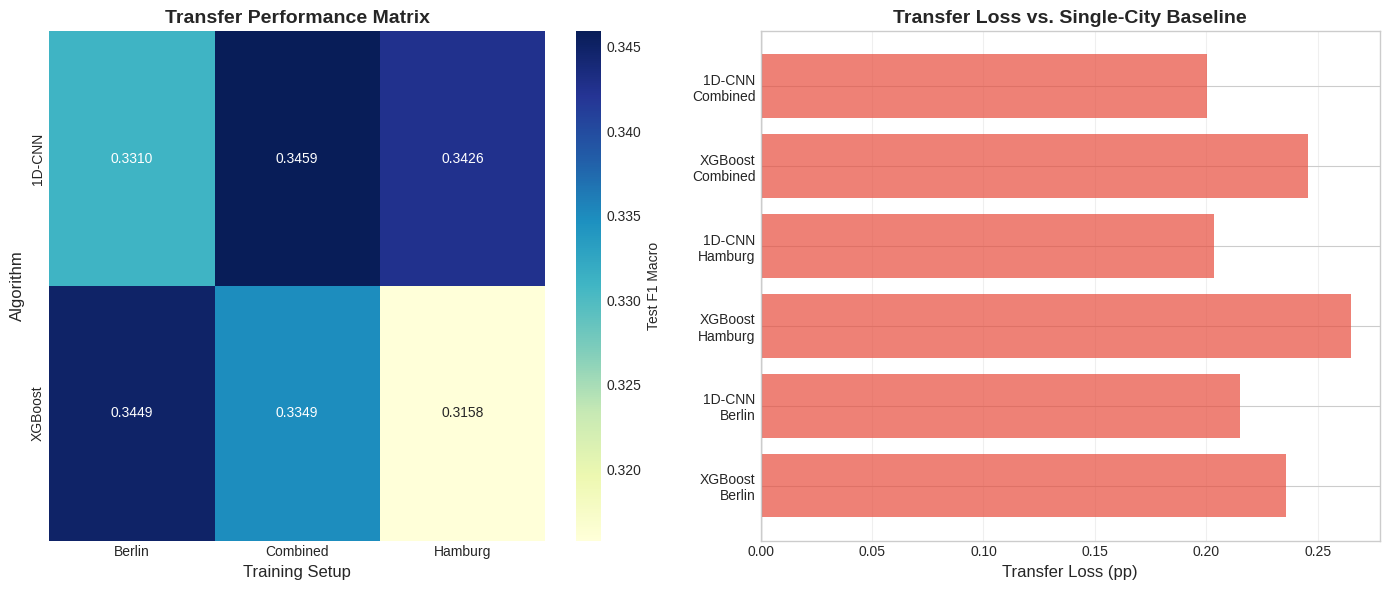

Visualizations saved


In [60]:
log_step("VISUALIZATION: Transfer Performance")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Performance Heatmap
ax1 = axes[0]
pivot_data = df_transfer.pivot(index='algorithm', columns='setup', values='test_f1_macro')
sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='YlGnBu', ax=ax1, cbar_kws={'label': 'Test F1 Macro'})
ax1.set_title('Transfer Performance Matrix', fontsize=14, fontweight='bold')
ax1.set_xlabel('Training Setup', fontsize=12)
ax1.set_ylabel('Algorithm', fontsize=12)

# Plot 2: Transfer Loss
ax2 = axes[1]
df_transfer_loss_plot = df_transfer_loss.copy()
df_transfer_loss_plot['label'] = df_transfer_loss_plot['algorithm'] + '\n' + df_transfer_loss_plot['setup']

colors = ['#e74c3c' if loss > 0 else '#2ecc71' for loss in df_transfer_loss_plot['transfer_loss_pp']]
ax2.barh(df_transfer_loss_plot['label'], df_transfer_loss_plot['transfer_loss_pp'], color=colors, alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_xlabel('Transfer Loss (pp)', fontsize=12)
ax2.set_title('Transfer Loss vs. Single-City Baseline', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PLOTS / 'transfer_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualizations saved")

---

## 8. SUMMARY & NEXT STEPS

### 8.1 Experiment Summary

In [61]:
log_step("SUMMARY: Phase 2 Transfer Evaluation Complete")

print("\n" + "="*70)
print("PHASE 2 COMPLETE: TRANSFER EVALUATION")
print("="*70)

print("\nExperiments Executed:")
print("  - Berlin → Rostock (XGBoost + 1D-CNN)")
print("  - Hamburg → Rostock (XGBoost + 1D-CNN)")
print("  - Combined → Rostock (XGBoost + 1D-CNN)")
print("  Total: 6 transfer experiments")

print("\nKey Findings:")
print(f"  Champion Algorithm: {champion_algorithm}")
print(f"    - Wins: {xgb_wins if champion_algorithm == 'XGBoost' else cnn_wins}/3 setups")
print(f"    - Avg Test F1: {best_algo['avg_test_f1']:.4f}")

print(f"\n  Best Training Setup: {champion_setup}")
print(f"    - Test F1: {best_setup_row['test_f1_macro']:.4f}")
print(f"    - Transfer Loss: {selected_transfer_setup['transfer_loss']['loss_pp']:.4f} ({selected_transfer_setup['transfer_loss']['loss_pct']:.1f}%)")

print("\nOutput Files Generated:")
files_to_check = {
    'selected_transfer_setup.json': OUTPUT_METADATA,
    'transfer_comparison.csv': OUTPUT_DATA,
    'transfer_loss_analysis.csv': OUTPUT_DATA,
    'transfer_evaluation.png': OUTPUT_PLOTS,
}

for file, folder in files_to_check.items():
    filepath = folder / file
    if filepath.exists():
        print(f"  {file} (in {folder.name})")
    else:
        print(f"  {file} (missing in {folder.name}!)")

print("\nNext Phase: Phase 2.2 - Champion Optimization")
print(f"  - Full Dataset Training ({champion_setup} setup)")
print(f"  - Optional HP-Tuning (if {champion_algorithm} Gap high)")
print(f"  - Genus-Level Analysis")
print(f"  - Training Data Scaling Curve")

print("\n" + "="*70)
print("READY FOR NOTEBOOK 2: CHAMPION OPTIMIZATION")
print("="*70)


[14:08:21] SUMMARY: Phase 2 Transfer Evaluation Complete

PHASE 2 COMPLETE: TRANSFER EVALUATION

Experiments Executed:
  - Berlin → Rostock (XGBoost + 1D-CNN)
  - Hamburg → Rostock (XGBoost + 1D-CNN)
  - Combined → Rostock (XGBoost + 1D-CNN)
  Total: 6 transfer experiments

Key Findings:
  Champion Algorithm: 1D-CNN
    - Wins: 2/3 setups
    - Avg Test F1: 0.3398

  Best Training Setup: Combined
    - Test F1: 0.3459
    - Transfer Loss: 0.2002 (36.7%)

Output Files Generated:
  selected_transfer_setup.json (in metadata)
  transfer_comparison.csv (in data)
  transfer_loss_analysis.csv (in data)
  transfer_evaluation.png (in plots)

Next Phase: Phase 2.2 - Champion Optimization
  - Full Dataset Training (Combined setup)
  - Optional HP-Tuning (if 1D-CNN Gap high)
  - Genus-Level Analysis
  - Training Data Scaling Curve

READY FOR NOTEBOOK 2: CHAMPION OPTIMIZATION


---

## END OF NOTEBOOK

**Phase 2.1 Status:** Complete  
**Next Notebook:** `02_champion_optimization.ipynb`